In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf #Adicionei como novo
plt.style.use('ggplot')

### Data Preprocessing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

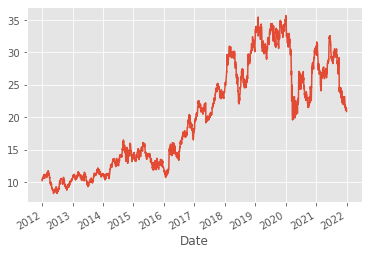

In [3]:
# Loading the dataset
df = yf.download(tickers='itub4.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [4]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.984085
High         0.985891
Low          0.983768
Close        0.984921
Adj Close    1.000000
Volume       0.137469
Name: Adj Close, dtype: float64

In [5]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    2.451000e+03
mean     2.454749e+07
std      1.315588e+07
min      2.128500e+04
25%      1.584870e+07
50%      2.131536e+07
75%      2.980703e+07
max      1.116226e+08
Name: Volume, dtype: float64


In [6]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [7]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [8]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [9]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [10]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [11]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

### Model Building

            Adj Close       Open        Low       High
Date                                                  
2012-01-02  10.201999  15.581813  15.253967  15.595473
2012-01-03  10.456821  15.518065  15.518065  15.882339
2012-01-04  10.468815  15.750290  15.609134  15.968854
2012-01-05  10.390875  15.732076  15.472531  15.941534
2012-01-06  10.468815  15.845912  15.722969  16.014387
...               ...        ...        ...        ...
2021-12-23  21.266260  21.330000  21.170000  21.570000
2021-12-27  21.485498  21.480000  21.309999  21.700001
2021-12-28  21.405773  21.629999  21.400000  21.700001
2021-12-29  21.226395  21.530001  21.230000  21.580000
2021-12-30  20.877607  21.440001  20.950001  21.440001

[2451 rows x 4 columns]


<AxesSubplot:xlabel='Date'>

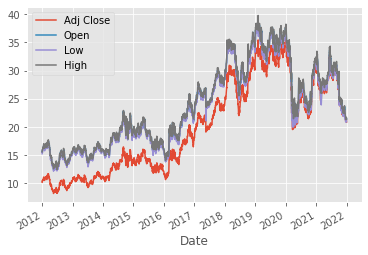

In [12]:
# Extracting the series
features = ['Adj Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series)
series.plot()

In [13]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1851, 4) (300, 4) (300, 4)


In [14]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1851, 4) (300, 4) (300, 4)


In [15]:
timesteps = 10
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 100

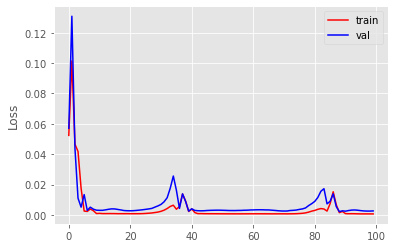

In [16]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.051108273996007675
MSE = 0.0036762262669331014
RMSE = 0.060631891500538736
R-Squared Score = 0.6728990895596667


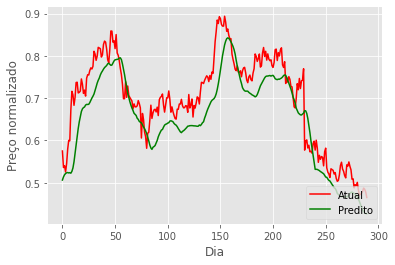

In [18]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [19]:
# Save a model
model.save('MV-LSTM ITUB4')
del model # Deletes the model
# Load a model
model = load_model('MV-LSTM ITUB4')

INFO:tensorflow:Assets written to: MV-LSTM ITUB4\assets


## Cross-Validation

In [20]:
# Hyperparameters
timesteps = 10
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [21]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2451, 4)
            Adj Close       Open        Low       High
Date                                                  
2021-12-23  21.266260  21.330000  21.170000  21.570000
2021-12-27  21.485498  21.480000  21.309999  21.700001
2021-12-28  21.405773  21.629999  21.400000  21.700001
2021-12-29  21.226395  21.530001  21.230000  21.580000
2021-12-30  20.877607  21.440001  20.950001  21.440001


In [22]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.07239972, 0.12312987, 0.11753034, 0.11286455],
       [0.08167381, 0.1207088 , 0.12759939, 0.12338298],
       [0.0821103 , 0.12952849, 0.13107148, 0.12655522],
       ...,
       [0.48015318, 0.35283497, 0.35185502, 0.33669792],
       [0.47362483, 0.34903711, 0.34537357, 0.33229788],
       [0.46093096, 0.34561898, 0.33469829, 0.32716455]])

### Split I

In [23]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.019631870712163834
MSE = 0.0006259122859549351
RMSE = 0.025018239065828257
R-Squared Score = 0.922181883841645


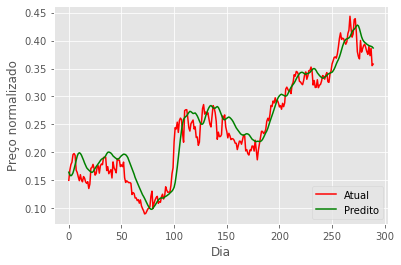

In [24]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split1.h5")

### Split II

Split 2
MAE = 0.016455782734430432
MSE = 0.0005528424221029392
RMSE = 0.02351260134699985
R-Squared Score = 0.9450201360284777


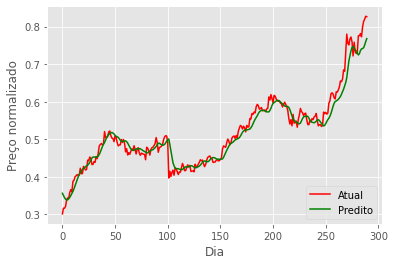

In [25]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split2.h5")

### Split III

Split 3
MAE = 0.03930465444334467
MSE = 0.002288055437191503
RMSE = 0.04783362245525111
R-Squared Score = 0.8280452029318175


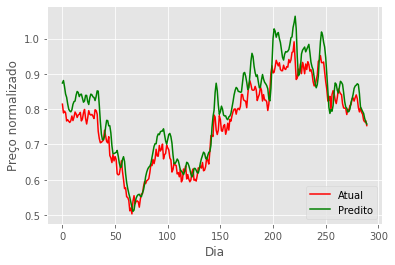

In [26]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split3.h5")

### Split IV

Split 4
MAE = 0.03928892825409146
MSE = 0.0024291534845221514
RMSE = 0.0492864432123292
R-Squared Score = 0.9155285775997408


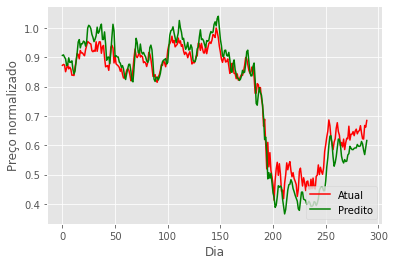

In [27]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split4.h5")

### Split V

Split 5
MAE = 0.04275624663440795
MSE = 0.002315695269556852
RMSE = 0.04812167151665507
R-Squared Score = 0.7757134402618021


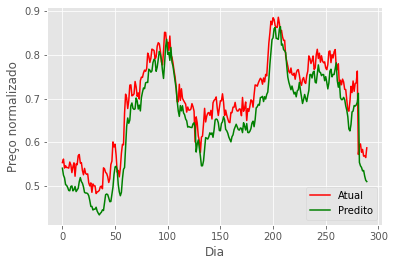

In [28]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split5.h5")

In [29]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.031487496555687666
Avg. MSE = 0.0016423317798656763
Avg. RMSE = 0.038754515519412704
Avg. R2-score = 0.8772978481326966


In [30]:
CV_results.to_csv('LSTM-M ITUB4.csv')
#train_loss.to_csv('PETR_MV3-LSTM_CrossValidation_TrainLoss.csv')
#val_loss.to_csv('PETR_MV3-LSTM_CrossValidation_ValLoss.csv')